<a href="https://colab.research.google.com/github/abhishekbm1996/Hindi-English_Transliteration/blob/main/Padhai_Capstone_13July2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Object(Text) Detection Model

In [ ]:
!nvidia-smi

Sat Dec  5 10:39:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installing Detectron2

Installing the Dependencies

In [ ]:
!pip install -q cython pyyaml==5.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

ERROR: detectron2 0.3 has requirement pycocotools>=2.0.2, but you'll have pycocotools 2.0 which is incompatible.


And download, compile, and install the Detectron2 package:

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.


In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
pycocotools 2.0.2
torch 1.7.0+cu101
torchvision 0.8.1+cu101
detectron2 0.3


In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import string

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

##Data Preprocessing for Transliteration Dataset



In [ ]:
dataset = []
for i,j,files in os.walk("/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/Train_Dataset_Images+Annotations_Reduced/Annotations_Reduced"):

  for file in tqdm(files):
    
    f = open(i+"/"+file, "r")
    for lines in f:

      data = {}

      an = lines.split(' ')

      image_file = file.replace("txt","jpg")

      image_size = Image.open("/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/Train_Dataset_Images+Annotations_Reduced/Images_Reduced/1/"+image_file)
      width, height = image_size.size

      data["image"] = image_file
      data["x1"] = int(float(an[0]))
      data["x2"] = int(float(an[1]))
      data["x3"] = int(float(an[2]))
      data["x4"] = int(float(an[3]))
      data["y1"] = int(float(an[4]))
      data["y2"] = int(float(an[5]))
      data["y3"] = int(float(an[6]))
      data["y4"] = int(float(an[7]))
      data["width"] = width
      data["height"] = height
      data["classes"] = "Text"
      dataset.append(data)
#print((dataset))

0it [00:00, ?it/s]
 16%|█▌        | 159/1001 [04:33<19:08,  1.36s/it]

KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(dataset)
print(type(df.x1[0]))
df.head() 

NameError: ignored

In [ ]:
print(df.image.unique().shape[0], df.shape[0])

1001 7044


In [ ]:
df.to_csv('/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/annotations.csv', header=True, index=None)

## Data Exploration

Let's see some sample annotated data. We'll use OpenCV to load an image, add the bounding boxes, and resize it. We'll define a helper function to do it all:

In [ ]:
def annotate_image(annotations, resize=True):
  file_name = annotations.image.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/Train_Dataset_Images+Annotations_Reduced/Images_Reduced/1/{file_name}'), cv2.COLOR_BGR2RGB)
  for i, a in annotations.iterrows():
    #print(type(a.x4), type(a.y4), type(a.x2), type(a.y2))
    cv2.rectangle(img, (a.x4, a.y4), (a.x2, a.y2), (0, 255, 0), 2)

  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

In [ ]:
img_df = df[df.image == df.image.unique()[400]]
img = annotate_image(img_df, resize=False)

plt.imshow(img)
plt.axis('off');

NameError: ignored

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/annotations.csv')
IMAGES_PATH = f'/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/Train_Dataset_Images+Annotations_Reduced/Images_Reduced/1'

unique_files = df.image.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.90), replace=False))
train_df = df[df.image.isin(train_files)]
test_df = df[~df.image.isin(train_files)]

train_df.head()

,image,x1,x2,x3,x4,y1,y2,y3,y4,width,height,classes
0,585.jpg,103,156,153,101,164,174,188,178,600,600,Text
1,585.jpg,229,304,296,221,30,40,100,90,600,600,Text
2,585.jpg,342,508,490,324,11,33,171,149,600,600,Text
3,585.jpg,200,244,239,195,91,95,153,149,600,600,Text
4,585.jpg,263,321,314,255,100,107,164,156,600,600,Text


In [ ]:
img = IMAGES_PATH+"/0.jpg"
print(img)

/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/Train_Dataset_Images+Annotations_Reduced/Images_Reduced/1/0.jpg


In [ ]:
classes = df.classes.unique().tolist()

In [ ]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.image.unique()):

    record = {}

    image_df = df[df.image == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int((image_df.iloc[0].height))
    record["width"] = int((image_df.iloc[0].width))

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x4)
      ymin = int(row.y4)
      xmax = int(row.x2)
      ymax = int(row.y2)

      poly = [
          (row.x4, row.y4), (row.x3, row.y3), 
          (row.x2, row.y2), (row.x1, row.y1)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.classes),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

##Training

We convert every annotation row to a single record with a list of annotations. You might also notice that we're building a polygon that is of the exact same shape as the bounding box. This is required for the image segmentation models in Detectron2.

You'll have to register your dataset into the dataset and metadata catalogues:

In [ ]:
for d in ["train", "val"]:
  DatasetCatalog.register("images_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("images_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("images_train")

AssertionError: ignored

In [ ]:
statement_metadata = MetadataCatalog.get("images_train")

Unfortunately, evaluator for the test set is not included by default. We can easily fix that by writing our own trainer:

In [ ]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

The evaluation results will be stored in the `coco_eval` folder if no folder is provided.

Fine-tuning a Detectron2 model is nothing like writing PyTorch code. We'll load a configuration file, change a few values, and start the training process. But hey, it really helps if you know what you're doing 😂

For this tutorial, we'll use the Mask R-CNN X101-FPN model. It is pre-trained on the [COCO dataset](http://cocodataset.org/#home) and achieves very good performance. The downside is that it is slow to train.

Let's load the config file and the pre-trained model weights:

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [ ]:
cfg.DATASETS.TRAIN = ("images_train",)
cfg.DATASETS.TEST = ("images_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [ ]:
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500
cfg.OUTPUT_DIR = "/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/output"

Time to train, using our custom trainer:



In [ ]:
!nvidia-smi

Sat Dec  5 10:41:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/05 10:43:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_2d9806.pkl:  39%|███▊      | 166M/431M [00:15<00:25, 10.6MB/s]


KeyboardInterrupt: ignored

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.92
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("images_val", cfg, False, output_dir="/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced/output")
val_loader = build_detection_test_loader(cfg, "images_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

## Finding texts in Images


Next, let's create a folder and save all images with predicted annotations in the test set.  We will crop the same for our next step

In [ ]:
import torch, torchvision

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import string

import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
os.makedirs("/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/annotated_results", exist_ok=True)

test_image_paths = test_df.image.unique()
print(test_image_paths)

['586.jpg' '597.jpg' '602.jpg' '603.jpg' '615.jpg' '637.jpg' '649.jpg'
 '657.jpg' '663.jpg' '667.jpg' '674.jpg' '677.jpg' '68.jpg' '680.jpg'
 '694.jpg' '701.jpg' '729.jpg' '73.jpg' '734.jpg' '755.jpg' '757.jpg'
 '766.jpg' '77.jpg' '778.jpg' '801.jpg' '803.jpg' '812.jpg' '827.jpg'
 '828.jpg' '830.jpg' '833.jpg' '862.jpg' '867.jpg' '869.jpg' '882.jpg'
 '890.jpg' '894.jpg' '896.jpg' '914.jpg' '92.jpg' '931.jpg' '933.jpg'
 '935.jpg' '946.jpg' '957.jpg' '97.jpg' '977.jpg' '994.jpg' '998.jpg'
 '999.jpg' '176.jpg' '183.jpg' '184.jpg' '185.jpg' '192.jpg' '199.jpg'
 '21.jpg' '213.jpg' '215.jpg' '256.jpg' '261.jpg' '260.jpg' '262.jpg'
 '264.jpg' '265.jpg' '266.jpg' '297.jpg' '308.jpg' '338.jpg' '351.jpg'
 '353.jpg' '37.jpg' '374.jpg' '386.jpg' '387.jpg' '389.jpg' '412.jpg'
 '429.jpg' '449.jpg' '450.jpg' '454.jpg' '455.jpg' '461.jpg' '481.jpg'
 '490.jpg' '493.jpg' '496.jpg' '504.jpg' '512.jpg' '527.jpg' '530.jpg'
 '532.jpg' '540.jpg' '544.jpg' '564.jpg' '113.jpg' '129.jpg' '152.jpg'
 '154.jpg' '1

In [ ]:
import tensorflow as tf

In [ ]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  #print(file_path)
  im = cv2.imread(file_path)
  outputs = predictor(im)
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  for i in range(0,len(instances)):
    
    result = tuple(instances[i].pred_boxes[0])
    result = result[0].numpy()
    x = int(result[0])
    y = int(result[1])
    w = int(result[2])
    h = int(result[3])
    cropped_img = im[y:h,x:w]
    file_name = clothing_image.split('.', 1)[0]+"_"+str(i)+".jpg"
    print(file_name)
    write_res = cv2.imwrite(f'/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/annotated_results/{file_name}', cropped_img)
  #cropped_img = im(y:y+h, x:x+w)
  #im = im(instances.pred_boxes[0])
  #v = v.draw_instance_predictions(instances)
  #print(instances.pred_boxes[0])
  #result = v.get_image()[:, :, ::-1]
  #file_name = ntpath.basename(clothing_image)

In [ ]:
file_name = "129_0.jpg"
annotated_images = f'/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/annotated_results/{file_name}'
print(annotated_images)

/content/drive/My Drive/Padhai_CapstoneProject_Dataset/FinalDataset_Reduced_R2/annotated_results/129_0.jpg


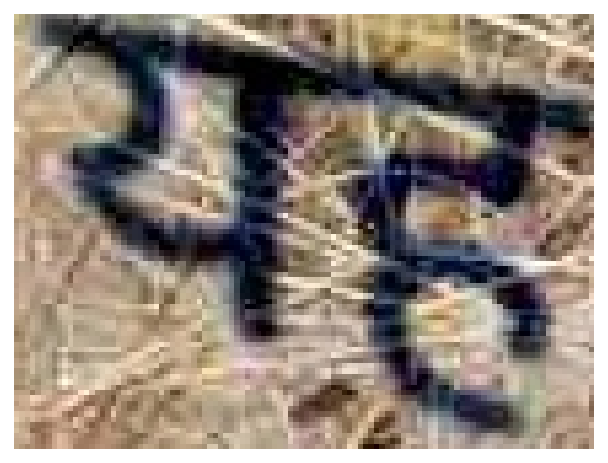

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

# Converting the text in the image to Unicode!!

In [ ]:
!nvidia-smi

Sat Dec  5 12:53:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   2929MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Installing the Dependencies

In [ ]:
import torch, torchvision
import torch.nn as nn
import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import string

import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
from torchvision import models

In [ ]:
resnet = models.resnet18(pretrained=True)
res50_conv = nn.Sequential(*list(resnet.children())[:-2])

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print(res50_conv)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256